In [166]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.spatial import distance
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from mpl_toolkits.axes_grid1 import make_axes_locatable
import string
from sklearn import preprocessing
import scipy.io
from scipy import stats
import math
import inspect,dis
from scipy.special import erf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
np.set_printoptions(suppress=True)

In [167]:
### Load experimental data (Di Cosmo et al., 2017)

HCdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') 
SCZdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') 
SPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') 
LSPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='low spq') 

sets = [HCdata,SCZdata,SPQdata,LSPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []
    
    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RTs = np.asarray(RTdata[0])[:,::-1]
SCZ_RTs = np.asarray(RTdata[1])[:,::-1]
SPQ_RTs = np.asarray(RTdata[2])[:,::-1]
LSPQ_RTs = np.asarray(RTdata[3])[:,::-1]

#idx = [4,10,13]
#SCZ_RTs = np.delete(SCZ_RTs, idx,axis=0)

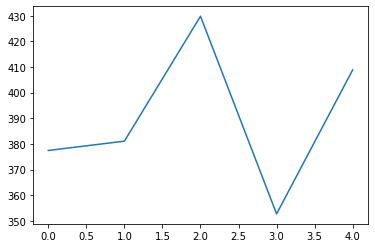

In [168]:
plt.plot(SCZ_RTs[10])

In [169]:
def RTsig(data,cp,h):
    global ymin
    global ymax
    return (ymin+ymax*np.exp((data-cp)/h)) / (1+np.exp((data-cp)/h))

## Sigmoid function fitting
def sigfit(x,y):
    global ymin
    global ymax
    
    k_0 = (ymax - ymin)/(x[-1]-x[0])
    initial_slope = (ymax - ymin)/(4*k_0)
    middle_x = np.max(x)/2
    init_guess = [middle_x, initial_slope]
    boundaries = ([0,float('-inf')],[float('inf'),float('inf')])
    
    popt, pcov = curve_fit(RTsig,x,y,p0=init_guess,method='trf',ftol=1e-8,xtol=1e-8,maxfev=10000,bounds=boundaries)
    sigpar = np.asarray(popt)
    dc = sigpar[0]
    h = sigpar[1]
    
    return dc,h

In [170]:
# Distance points in cm (network coordinates) 
a_distances = np.asarray([2700,2200,1500,800,300])

RTdata = []

n_sample = np.size(HC_RTs,0)
parc = np.zeros((n_sample,3))
pard = np.zeros((n_sample,3))
    
for s in np.arange(n_sample):
    rt_data = HC_RTs[s,:]
    ymin, ymax = np.min(rt_data), np.max(rt_data)
    pars = sigfit(a_distances,rt_data) 
    fit = RTsig(a_distances,*pars)
    r2 = r2_score(rt_data,fit)
    parc[s,:] = [*pars,r2]

for s in np.arange(n_sample-3):
    rt_data = SCZ_RTs[s,:]
    ymin, ymax = np.min(rt_data), np.max(rt_data)
    pars = sigfit(a_distances,rt_data) 
    fit = RTsig(a_distances,*pars)
    r2 = r2_score(rt_data,fit)
    pard[s,:] = [*pars,r2]

RTdata.append(parc)
RTdata.append(pard)

n_sample = np.size(SPQ_RTs,0)
parc = np.zeros((n_sample,3))
pard = np.zeros((n_sample+1,3))
    
for s in np.arange(n_sample):
    rt_data = SPQ_RTs[s,:]
    ymin, ymax = np.min(rt_data), np.max(rt_data)
    pars = sigfit(a_distances,rt_data) 
    fit = RTsig(a_distances,*pars)
    r2 = r2_score(rt_data,fit)
    parc[s,:] = [*pars,r2]
    
for s in np.arange(n_sample+1):
    rt_data = LSPQ_RTs[s,:]
    ymin, ymax = np.min(rt_data), np.max(rt_data)
    pars = sigfit(a_distances,rt_data) 
    fit = RTsig(a_distances,*pars)
    r2 = r2_score(rt_data,fit)
    pard[s,:] = [*pars,r2]
    
RTdata.append(parc)
RTdata.append(pard)

HC_pars = RTdata[0]#[~np.isnan(RTdata[0]).any(axis=1)]
SCZ_pars = RTdata[1]#[~np.isnan(RTdata[1]).any(axis=1)]
SPQ_pars = RTdata[2]#[~np.isnan(RTdata[2]).any(axis=1)]
LSPQ_pars = RTdata[3]#[~np.isnan(RTdata[3]).any(axis=1)]

In [171]:
#print(SCZ_pars)#[4,10,13]
SCZ_pars = SCZ_pars[SCZ_pars[:,2] > 0.25]
print(HC_pars)

[[ 731.59308097  -49.21397846    0.94476297]
 [1769.2226203  -262.81044854    0.99883307]
 [1169.83188187 -368.76994551    0.95283654]
 [1884.10382338 -496.41801128    0.8337627 ]
 [ 758.79465327  -35.118212      0.98951787]
 [1127.59564412 -339.78965226    0.95284457]
 [1305.0887779   -98.40302545    0.80339345]
 [ 787.46592969  -80.57102707    0.90579184]
 [2009.17441292 -485.59957181    0.84111619]
 [1363.17422842 -594.15175061    0.79165309]
 [1444.78158532 -470.23581171    0.80705698]
 [1285.14967523 -107.3591462     0.70127705]
 [1483.77489173 -703.75542278    0.7661565 ]
 [1360.73684204 -477.03365604    0.66188048]
 [1463.4926458  -171.67147401    0.90558649]
 [1515.65716963  -85.935638      0.99133368]
 [1103.67318199 -493.80179672    0.89721968]
 [1357.9339604  -195.42536464    0.9827634 ]]


In [172]:
print(np.median(HC_pars[:,0]))
print(np.median(HC_pars[:,1]))

print(np.median(SCZ_pars[:,0]))
print(np.median(SCZ_pars[:,1]))

1359.335401220596
-301.3000503997779
1648.0779807931594
-195.09829689238066


In [176]:
dset = SPQ_RTs

n_size = dset.shape[0]

mins = []
maxs = []

for i in range(n_size):
    mini,maxi = np.min(dset[i]), np.max(dset[i])
    mins.append(mini)
    maxs.append(maxi)
    
print(np.mean(mins))
print(np.mean(maxs))

267.49264705882354
344.6744295011452
